<a href="https://colab.research.google.com/github/aRod209/pytorch-for-deep-learning/blob/main/lectures/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Dataasets Video Notebook

We've used some datasets with PyTorch before.

But how do we get your own data in PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04:

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
torch.__version__

'2.1.0+cu121'

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
if device == 'cuda':
  !nvidia-smi

## 1. Get Data

Our dataset is a subset of the [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

data_path, image_path

(PosixPath('data'), PosixPath('data/pizza_steak_sushi'))

In [5]:
# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f'{image_path} directory already exists... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

data/pizza_steak_sushi directory already exists... skipping download


In [6]:
# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print(f'Downloading pizza, steak, and sushi data...')
  f.write(response.content)

In [7]:
# Unzip pizza, steak, and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping pizza, steak, and sushi data...')
  zip_ref.extractall(image_path)

Unzipping pizza, steak, and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [8]:
import os
def walk_through_dir(dir_root):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_root):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [9]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak


In [10]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images let's open the image with Python's PIL
5. We'll then show the image and  print metadata

In [11]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/sushi/1615453.jpg
Image class: sushi
Image height: 512
Image width: 384


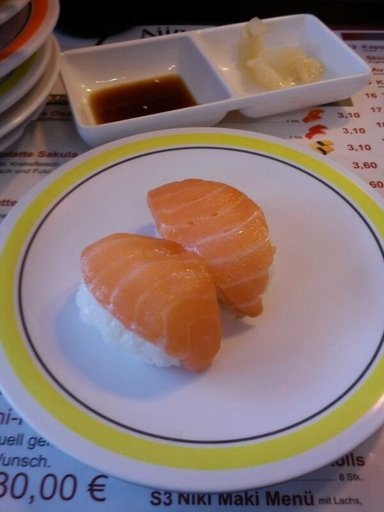

In [12]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all of the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path using Python's random.choice()
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

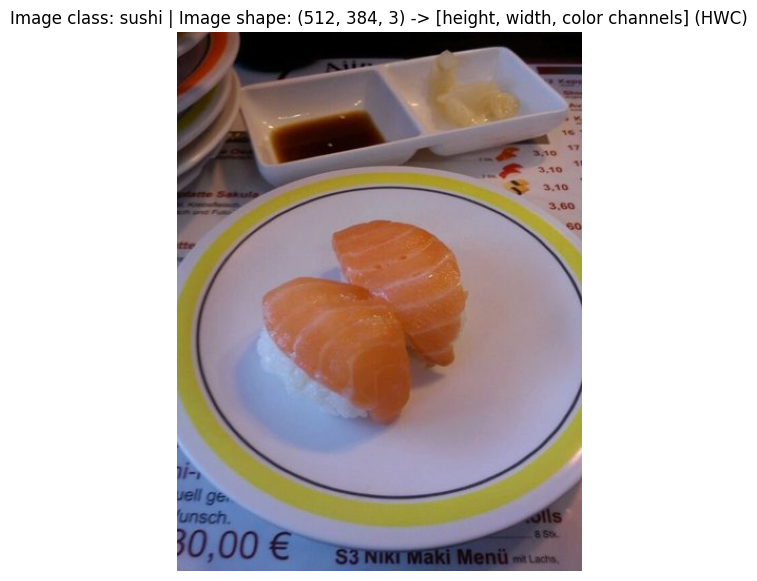

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels] (HWC)')
plt.axis(False);

array([[[ 58,  19,   0],
        [ 59,  23,   0],
        [ 63,  26,   0],
        ...,
        [  7,   7,   9],
        [  7,   7,   9],
        [  7,   7,   9]],

       [[ 62,  23,   0],
        [ 62,  25,   0],
        [ 64,  29,   1],
        ...,
        [  6,   6,   8],
        [  6,   6,   8],
        [  6,   6,   8]],

       [[ 65,  28,   1],
        [ 65,  30,   2],
        [ 66,  32,   5],
        ...,
        [  5,   5,   7],
        [  5,   5,   7],
        [  5,   5,   7]],

       ...,

       [[121, 124, 169],
        [120, 124, 169],
        [123, 126, 171],
        ...,
        [120,  98, 110],
        [120,  98, 110],
        [120,  98, 110]],

       [[120, 125, 167],
        [119, 126, 168],
        [122, 127, 169],
        ...,
        [119,  97, 109],
        [120,  98, 110],
        [121,  99, 111]],

       [[119, 126, 168],
        [120, 127, 169],
        [120, 127, 169],
        ...,
        [119,  97, 109],
        [120,  98, 110],
        [121,  99, 111]]], dtype=uint8)
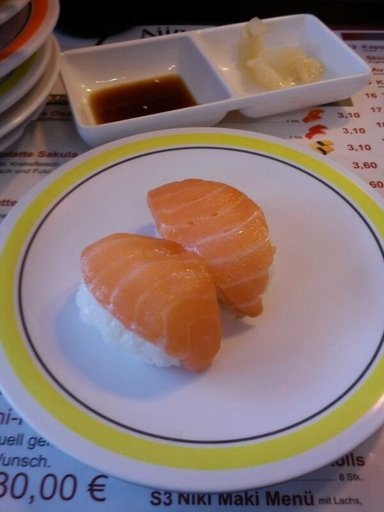

In [14]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our caase, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 # Lecture uses version 1, I will use version 2.

### 3.1 Transforming data with `torchvision.transform`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [16]:
# Write a transform for image.
data_transform = v2.Compose([
    # Turn the image into a torch.Tensor
    v2.ToImage(),
    # Resize our images to 64x64
    v2.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    v2.RandomHorizontalFlip(p=0.5),
])

In [17]:
data_transform(img).dtype, data_transform(img).shape, data_transform(img)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.uint8,
 torch.Size([3, 64, 64]),
 Image([[[  3,   1,   1,  ..., 109,  85,  67],
         [  2,   1,   1,  ...,  80,  85,  82],
         [  2,   1,   1,  ...,  39,  46,  94],
         ...,
         [125, 123, 120,  ...,  93, 105,  88],
         [120, 122, 119,  ..., 108, 118, 122],
         [121, 120, 117,  ..., 122, 127, 126]],
 
        [[  3,   1,   1,  ...,  81,  64,  39],
         [  2,   1,   1,  ...,  68,  69,  63],
         [  2,   1,   1,  ...,  23,  27,  75],
         ...,
         [ 98,  97,  94,  ...,  99, 104,  71],
         [ 96,  99,  97,  ..., 109, 126, 124],
         [ 99, 100,  97,  ..., 128, 129, 128]],
 
        [[  5,   3,   3,  ...,  75,  53,  17],
         [  1,   1,   1,  ...,  68,  74,  65],
         [  1,   1,   1,  ...,  17,  29,  77],
         ...,
         [107, 110, 103,  ..., 144, 151, 107],
         [110, 111, 108,  ..., 151, 174, 166],
         [111, 112, 111,  ..., 177, 178, 174]]], dtype=torch.uint8, ))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


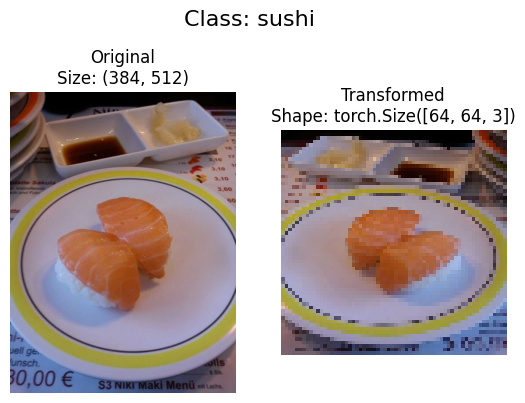

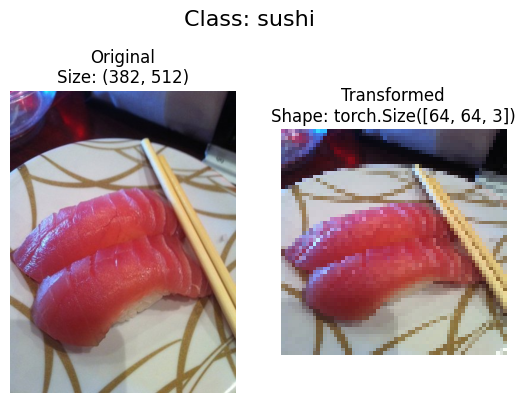

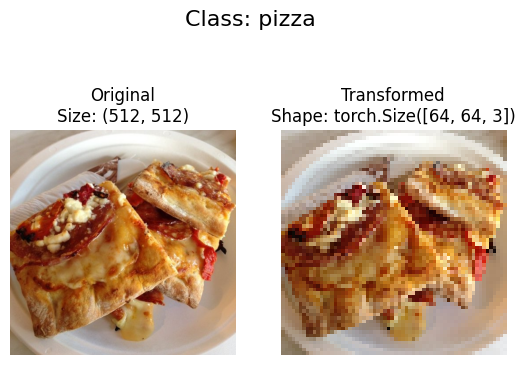

In [21]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs the transformed version.
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as image:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(image)
      ax[0].set_title(f'Original\nSize: {image.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(image).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [22]:
# Use Image Folder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  RandomHorizontalFlip(p=0.5)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  RandomHorizontalFlip(p=0.5)
            ))

In [25]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [24]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [26]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [27]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [31]:
# Check a target and the corresponding sample of the target
train_data.targets[0], train_data.samples[0]

(0, ('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0))